In [1]:
# Simple simulation of metastasis to test the assumptions of the met-score metrics

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as ss
import sklearn.metrics as sklm
from tqdm import tqdm_notebook, tqdm
import scipy.stats as scs
import networkx as nx

from collections import defaultdict

import subprocess
import os

import seaborn as sns

from cassiopeia.TreeSolver.simulation_tools import dataset_generation as data_gen
from cassiopeia.TreeSolver.simulation_tools.simulation_utils import get_leaves_of_tree

import utilities.metastasis_score_utils as met_utils
import utilities.compute_transition_probs as ctp

from cassiopeia.TreeSolver.Cassiopeia_Tree import Cassiopeia_Tree
from cassiopeia.TreeSolver.Node import Node
from cassiopeia.Analysis import reconstruct_states
from cassiopeia.Analysis import fitch_parsimony

import pickle as pic

from rpy2.robjects import pandas2ri
import anndata2ri

import rpy2
import logging 

In [6]:
def compute_priors(C, S, p, mean=0.01, disp=0.1, empirical = np.array([])):
    
    sp = {}
    prior_probabilities = {}
    for i in range(0, C):
        if len(empirical) > 0:
            sampled_probabilities = sorted(empirical)
        else:
            sampled_probabilities = sorted([np.random.negative_binomial(mean,disp) for _ in range(1,S+1)])
        mut_rate = p
        prior_probabilities[i] = {'0': (1-mut_rate)}
        total = np.sum(sampled_probabilities)

        sampled_probabilities = list(map(lambda x: x / (1.0 * total), sampled_probabilities))
            
        for j in range(1, S+1):
            prior_probabilities[i][str(j)] = (mut_rate)*sampled_probabilities[j-1]

    return prior_probabilities, sp 

def get_transition_stats(tree):
    
    n_transitions = 0
    transitions = defaultdict(dict)
    freqs = defaultdict(int)
    
    root = [n for n in tree if tree.in_degree(n) == 0][0]
    for e in nx.dfs_edges(tree, source=root):
        
        p,c = e[0], e[1]
        m_p, m_c = tree.nodes[p]['meta'], tree.nodes[c]['meta']
        if m_p != m_c:
            n_transitions += 1
            if m_c not in transitions[m_p]:
                transitions[m_p][m_c] = 0
            transitions[m_p][m_c] += 1
            
        if tree.out_degree(c) == 0:
            freqs[m_c] += 1
            
    return n_transitions, transitions, freqs

In [7]:
no_mut_rate = 0.985
number_of_states = 40
dropout = 0.17
depth = 8
number_of_characters = 40

pp, sp = compute_priors(number_of_characters, number_of_states, 0.025, mean=1, disp=0.1)


In [8]:
# define parameters:
N_clones = 100 #number of clones to simulate
max_mu = 0.3 #max rate of metastasis
min_alpha = 0.75 #min rate of doubling
t_range = [12,16] #range of time-steps
sigma = 6 #number of tumor samples
beta = 0.00 #extinction rate

# make samples
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
sample_list = [alphabet[i] for i in range(sigma)]

# generate color list
cmap = plt.cm.get_cmap('Blues')
cmap_list = []
for i in range(len(sample_list)):
    cmap_list.append(cmap(i/len(sample_list)))

# Simulate trees with metastsis

In [18]:
import cassiopeia.TreeSolver.compute_meta_purity as cmp

def assign_majority_vote(t, root):
    
    def majority_vote(tree, rt):
        
        children = [node for node in nx.dfs_preorder_nodes(tree, rt) if tree.out_degree(node) == 0]
        children_vals = [tree.nodes[n]["label"] for n in children]
            
        uniq_count = np.unique(children_vals, return_counts=True)
        label = uniq_count[0][np.argmax(uniq_count[1])]
        
        return label
        
    for n in nx.dfs_preorder_nodes(t, root):
        
        if t.out_degree(n) == 0:
            t.nodes[n]['label'] = t.nodes[n]['label'][0]
        
        t.nodes[n]['label'] = majority_vote(t, n)
        
    return t
    

def compute_transitions_majority_vote(t, meta):
    
    possible_labels = meta.unique()
    
    M = len(possible_labels)
    C = np.zeros((M, M))
    label_to_j = dict(zip(possible_labels, range(len(possible_labels))))
    
    root = [n for n in t if t.in_degree(n) == 0][0]
    t = ctp.assign_labels(t, meta)
    
    t = cmp.set_depth(t, root)
    
    t = assign_majority_vote(t, root)
    
    # now count transitions
    for v in nx.dfs_postorder_nodes(t, source=root):
    
        v_lab = t.nodes[v]['label']
        i = label_to_j[v_lab]

        children = list(t.successors(v))
        for c in children:
            
            c_lab = t.nodes[c]['label']
            j = label_to_j[c_lab]

            C[i, j] += 1
    
    count_mat = pd.DataFrame(C)
    count_mat.columns = possible_labels
    count_mat.index = possible_labels
    return count_mat

def kl_divergence(a, b):
    
    kl_a = np.sum([a[i]*np.log(a[i]/b[i]) for i in range(len(a))])
    kl_b = np.sum([b[i] * np.log(b[i]/a[i]) for i in range(len(b))])
    
    return kl_a + kl_b

Generating cells at each level in tree: 100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


0.9188952757580147


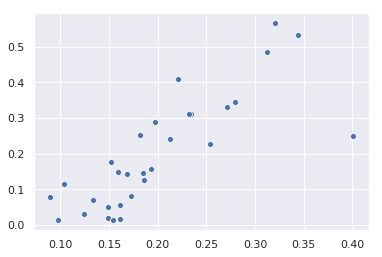

0.9021111913429206


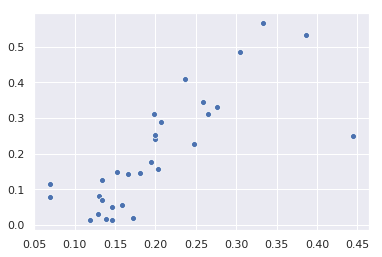

0.7503405210331718


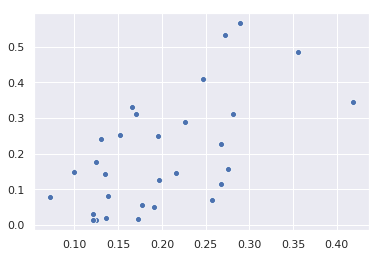

In [19]:
alpha = 1

tmat = pd.DataFrame(np.zeros((6,6)), index=sample_list,  columns=sample_list)

for i in tmat.index:
    thetas = np.random.dirichlet([alpha]*(sigma-1))
    tmat.loc[i, [j for j in tmat.columns if j != i]] = thetas

    
tree, params = data_gen.generate_simulated_experiment_plasticisity(pp,
        [0.18]*number_of_characters,
        characters=number_of_characters,
        subsample_percentage=0.5,
        dropout=True, 
        sample_list = sample_list, 
        max_mu = 0.7, 
        min_alpha = min_alpha,
        depth = 11,
        beta = 0,
        transition_matrix = tmat
        )

n_mets, mets, freqs = get_transition_stats(tree.network)

leaves = [n for n in tree.network if tree.network.out_degree(n) == 0]
t = tree.network
t2 = t.copy()

meta = pd.DataFrame.from_dict(dict(zip([n.name for n in leaves], [tree.network.nodes[n]['meta'] for n in leaves])), orient='index')
est_freqs_naive = reconstruct_states.naive_fitch(t2, meta.loc[:,0])
est_freqs = reconstruct_states.fitch_count(t, meta.loc[:,0], count_unique = False)
est_freqs_mv = compute_transitions_majority_vote(t, meta.iloc[:, 0])


metsdf = pd.DataFrame.from_dict(mets, orient='index').loc[sample_list, sample_list]
est_freqs = est_freqs.loc[sample_list, sample_list]
est_freqs_naive = est_freqs_naive.loc[sample_list, sample_list]
est_freqs_mv = est_freqs_mv.loc[sample_list, sample_list]

np.fill_diagonal(est_freqs.values,0)
est_freqs = est_freqs.fillna(value = 0)
est_freqs = est_freqs.apply(lambda x: x / max(1, x.sum()), axis=1)

np.fill_diagonal(est_freqs_naive.values,0)
est_freqs_naive = est_freqs_naive.fillna(value = 0)
est_freqs_naive = est_freqs_naive.apply(lambda x: x/max(1, x.sum()), axis=1)

np.fill_diagonal(est_freqs_mv.values,0)
est_freqs_mv = est_freqs_mv.fillna(value = 0)
est_freqs_mv = est_freqs_mv.apply(lambda x: x/max(1, x.sum()), axis=1)

np.fill_diagonal(metsdf.values,0)
metsdf = metsdf.fillna(value = 0)
metsdf = metsdf.apply(lambda x: x / max(1, x.sum()), axis=1)

x, y = [], []
for i in range(sigma):
    for j in range(sigma):
        if i != j:
            x.append(est_freqs.iloc[i, j])
            y.append(tmat.iloc[i, j])
            
scorr_fitcher = scs.spearmanr(metsdf.values.ravel(), est_freqs.values.ravel())[0]
print(scorr_fitcher)

sns.scatterplot(x, y)
plt.show()

x, y = [], []
for i in range(sigma):
    for j in range(sigma):
        if i != j:
            x.append(est_freqs_naive.iloc[i, j])
            y.append(tmat.iloc[i, j])
            
scorr_naive = scs.spearmanr(metsdf.values.ravel(), est_freqs_naive.values.ravel())[0]

print(scorr_naive)
sns.scatterplot(x, y)
plt.show()

x, y = [], []
for i in range(sigma):
    for j in range(sigma):
        if i != j:
            x.append(est_freqs_mv.iloc[i, j])
            y.append(tmat.iloc[i, j])

            
scorr_mv = scs.spearmanr(metsdf.values.ravel(), est_freqs_mv.values.ravel())[0]

print(scorr_mv)
sns.scatterplot(x, y)
plt.show()


In [471]:
fres1 = pd.read_csv("fitcher_benchmark.concentrated.txt", sep='\t', index_col = 0) # actually 'uniform' transitions
fres2 = pd.read_csv("fitcher_benchmark.uniform.txt", sep='\t', index_col = 0) # actually biased transitions

fitcher = fres1['FITCHER_KL'].values
naive = fres1['NAIVE_KL'].values

In [472]:
fres2.head(5)

,mu,alpha,N,n_mets,DynMet,FITCHER_KL,NAIVE_KL,MAJORITYVOTE_KL,FITCHER_SCORR,NAIVE_SCORR,MAJORITYVOTE_SCORR,A,B,C,D,E,F
0,0.104084,0.866722,656,139,0.100763,NaN,NaN,NaN,0.830099,0.786673,0.504903,53.0,76.0,28.0,263.0,148.0,88.0
1,0.187243,0.793254,295,110,0.154762,NaN,NaN,NaN,0.707455,0.623172,0.682186,35.0,90.0,46.0,34.0,23.0,67.0
2,0.186765,0.779918,444,171,0.169300,NaN,NaN,2.381001,0.793912,0.764066,0.789269,36.0,60.0,102.0,67.0,78.0,101.0
3,0.141995,0.957997,845,239,0.129739,NaN,NaN,NaN,0.867220,0.857664,0.772084,79.0,16.0,341.0,65.0,178.0,166.0
4,0.128295,0.907094,662,174,0.117247,NaN,NaN,NaN,0.839525,0.799096,0.781643,23.0,27.0,232.0,48.0,295.0,37.0


0.8554621848739494 0.8442789254658247 0.7047606387489206 0.11469272552181983 0.1240187577898286


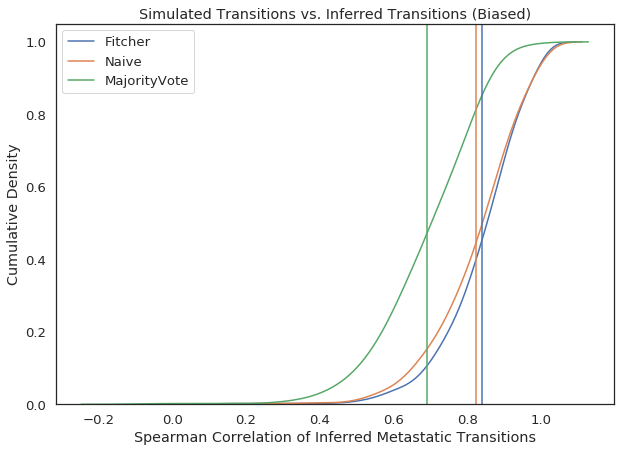

In [473]:

klf = [c for c in fres2['FITCHER_SCORR'].values if not np.isnan(c)]
kln = [c for c in fres2['NAIVE_SCORR'].values if not np.isnan(c)]
klmv = [c for c in fres2['MAJORITYVOTE_SCORR'].values if not np.isnan(c)]


print(np.median(klf), np.median(kln), np.median(klmv), np.std(klf), np.std(kln))

h = plt.figure(figsize=(10, 7))
sns.distplot(klf, hist=False, kde_kws={'cumulative': True}, label='Fitcher')
sns.distplot(kln, hist=False, kde_kws={'cumulative': True}, label='Naive')
sns.distplot(klmv, hist=False, kde_kws={'cumulative': True}, label='MajorityVote')
plt.axvline(np.mean(klf), color = 'C0')
plt.axvline(np.mean(kln), color = 'C1')
plt.axvline(np.mean(klmv), color = 'C2')
plt.xlabel("Spearman Correlation of Inferred Metastatic Transitions")
plt.ylabel("Cumulative Density")
plt.xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.legend()
plt.title('Simulated Transitions vs. Inferred Transitions (Biased)')
# plt.savefig('tmat_inference.biased.eps')
plt.show()


In [167]:
columner1 = ['mu', 'alpha', 'N', 'n_mets', 'NN_met', 'DynMet']
columner2 = [sample_list[i] for i in range(len(sample_list))]
masterDF = pd.DataFrame(columns=columner1+columner2)

for i in range(N_clones):
    if i % 10 == 0:
        print(i)
        
    pp, sp = compute_priors(number_of_characters, number_of_states, 0.05, mean=1, disp=0.1)

    tree, params = data_gen.generate_simulated_experiment_plasticity(pp,
        [0.18]*number_of_characters,
        characters=number_of_characters,
        subsample_percentage=0.5,
        dropout=True, 
        sample_list = sample_list, 
        max_mu = 0.4, 
        min_alpha = min_alpha,
        depth = 9, 
        beta = 0,
        )
    
    n_mets, mets, freqs = get_transition_stats(tree.network)
    
    leaves = [n for n in tree.network if tree.network.out_degree(n) == 0]
    meta = pd.DataFrame.from_dict(dict(zip([l.name for l in leaves], [tree.network.nodes[l]['meta'] for l in leaves])), orient='index', columns = ['sample'])
    nn_met = met_utils.compute_NN_metastasis_score(tree.network, meta['sample'], _method = 'allele', verbose=False)
    norm_fitch = met_utils.compute_dynamic_metastasis_score(tree.network, meta['sample'])
    
    masterDF.loc[i, 'mu'] = params['mu']
    masterDF.loc[i, 'alpha'] = params['alpha']
    masterDF.loc[i, 'N'] = params['N']
    masterDF.loc[i, 'n_mets'] = n_mets
    masterDF.loc[i, 'NN_met'] = nn_met
    masterDF.loc[i, 'DynMet'] = norm_fitch
    
    for k in freqs:
        masterDF.loc[i, k] = freqs[k]

Generating cells at each level in tree:  78%|███████▊  | 7/9 [00:00<00:00, 14.12it/s]

0


Generating cells at each level in tree:  89%|████████▉ | 8/9 [00:00<00:00, 70.92it/s]

10


Generating cells at each level in tree:  78%|███████▊  | 7/9 [00:00<00:00, 16.37it/s]

20


Generating cells at each level in tree:  89%|████████▉ | 8/9 [00:00<00:00, 14.42it/s]

30


Generating cells at each level in tree:  89%|████████▉ | 8/9 [00:00<00:00, 15.15it/s]

40


Generating cells at each level in tree:  78%|███████▊  | 7/9 [00:00<00:00, 15.37it/s]

50


Generating cells at each level in tree:  78%|███████▊  | 7/9 [00:00<00:00, 17.54it/s]

60


Generating cells at each level in tree: 100%|██████████| 9/9 [00:00<00:00, 12.61it/s]

70



Generating cells at each level in tree:  78%|███████▊  | 7/9 [00:00<00:00, 15.61it/s]

80


Generating cells at each level in tree:  78%|███████▊  | 7/9 [00:00<00:00, 12.83it/s]

90


Creating pairs to compare: 100%|██████████| 141/141 [00:00<00:00, 25961.23it/s]


In [374]:
## read in previous met sim results
masterDF = pd.read_csv("data/simulations/met_sim_df.txt", sep='\t', index_col = 0)
print(masterDF.shape)

(1000, 14)


In [412]:
masterDF.fillna(0, inplace=True)
masterDF['Norm_mets'] = masterDF['n_mets'].div(masterDF['N'] * 2)

masterDF.head(5)

,mu,alpha,N,n_mets,NN_met,DynMet,A,B,C,D,E,F,Norm_mets,CV
0,0.277662,0.841051,5332,2968,0.703989,0.221159,808.0,897.0,935.0,908.0,888.0,896.0,0.278320,0.965832
1,0.238290,0.990001,15773,7553,0.653602,0.196170,3080.0,2528.0,2631.0,2586.0,2464.0,2484.0,0.239428,0.951936
2,0.082923,0.752288,1970,334,0.350948,0.081260,145.0,157.0,127.0,824.0,551.0,166.0,0.084772,0.628031
3,0.033863,0.804895,4067,283,0.183978,0.034555,107.0,172.0,173.0,3246.0,160.0,209.0,0.034792,0.371085
4,0.257002,0.799269,5607,2895,0.671110,0.209864,918.0,906.0,806.0,1009.0,924.0,1044.0,0.258159,0.975945


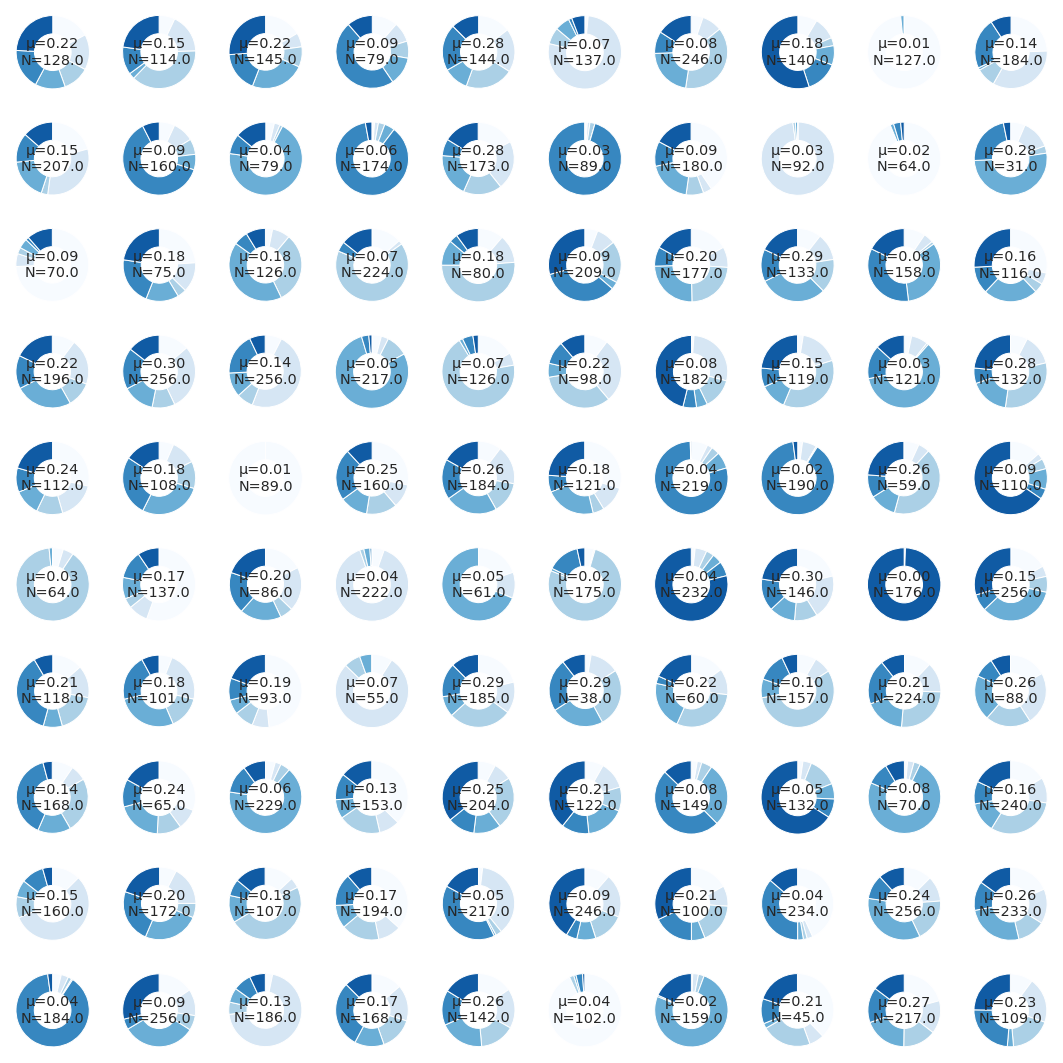

In [159]:
# Subplot distribution of UMI per cell per sample
f, axarr = plt.subplots(10, 10, figsize=(15,15))

for j in range(0,100):
    x = int((j)/10)
    y = int((j)%10)
    
    cellspersample = masterDF.iloc[j][sample_list].tolist()
    axarr[x,y].pie(cellspersample, colors=cmap_list, startangle=90, counterclock=False, wedgeprops=dict(width=0.5))
    axarr[x,y].text(0, 0, "µ="+"%.2f" % masterDF.iloc[j]['mu'] +"\nN="+str(masterDF.iloc[j]['N']), ha='center', va='center')
    axarr[x,y].axis('equal')
       
plt.tight_layout()

In [171]:

# find background distribution across all clones
background = masterDF.filter(sample_list, axis=1).sum(axis=0)
masterDF['CV'] = 0
cramers_list = []
for k in tqdm(range(0, masterDF.shape[0])):
    
    query = masterDF.iloc[k][sample_list]

    query = pd.DataFrame(query)

    table = pd.concat([background, query], axis=1)
    table.fillna(value = 0, inplace=True)
    table.columns = ["Background", "LG"]
    table["Background"] = table["Background"] - table["LG"]

    
    table = met_utils.scale_counts(table)
    stat = scs.chi2_contingency(table)[0]
    v = met_utils.cramers_v(stat, np.sum(table.sum()), table.shape[0], table.shape[1])
    cramers_list.append(1-v)
    
    masterDF.loc[k, 'CV'] = (1-v)
    

100%|██████████| 100/100 [00:00<00:00, 167.58it/s]


In [80]:
masterDF = masterDF[masterDF['mu'] <= 0.3]

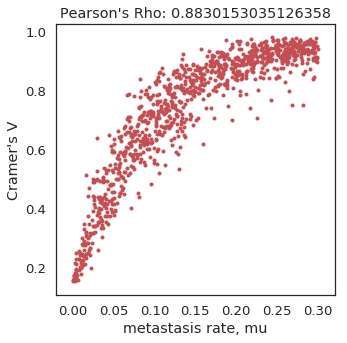

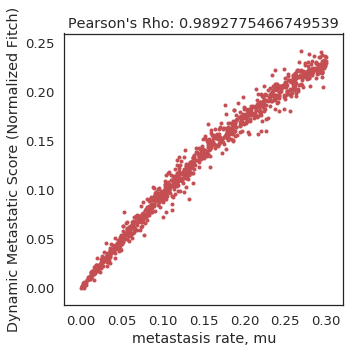

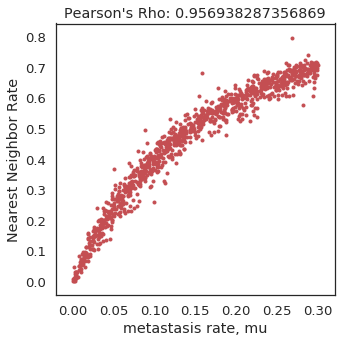

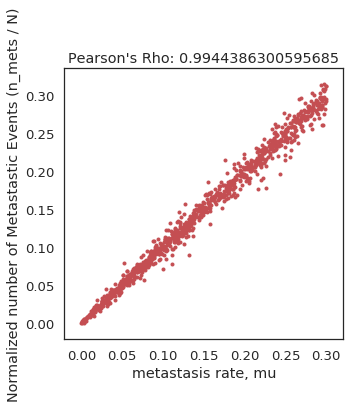

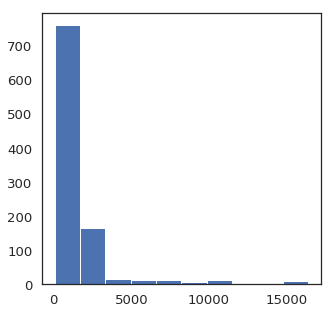

In [413]:
# plot distribution
h = plt.figure(1,figsize=(5,5))
scat = plt.scatter(masterDF['mu'], masterDF['CV'], color='r', marker='.')
xlab = plt.xlabel('metastasis rate, mu')
ylab = plt.ylabel("Cramer's V")
plt.title("Pearson's Rho: " + str(scs.pearsonr(masterDF['mu'], masterDF['CV'])[0]))
# plt.savefig('sim_mu_vs_cv.png')
plt.show()

# plot distribution
h = plt.figure(1,figsize=(5,5))
scat = plt.scatter(masterDF['mu'], masterDF['DynMet'], color='r', marker='.', alpha=1)
xlab = plt.xlabel('metastasis rate, mu')
ylab = plt.ylabel('Dynamic Metastatic Score (Normalized Fitch)')
plt.title("Pearson's Rho: " + str(scs.pearsonr(masterDF['mu'], masterDF['DynMet'])[0]))
# plt.savefig('sim_mu_vs_dynmet.png')
plt.show()

h = plt.figure(1,figsize=(5,5))
scat = plt.scatter(masterDF['mu'], masterDF['NN_met'], color='r', marker='.', alpha=1)
xlab = plt.xlabel('metastasis rate, mu')
ylab = plt.ylabel('Nearest Neighbor Rate')
plt.title("Pearson's Rho: " + str(scs.pearsonr(masterDF['mu'], masterDF['NN_met'])[0]))
# plt.savefig('sim_mu_vs_nn.png')
plt.show()

h = plt.figure(1,figsize=(5,5))
scat = plt.scatter(masterDF['mu'], masterDF['Norm_mets'], color='r', marker='.', alpha=1)
xlab = plt.xlabel('metastasis rate, mu')
ylab = plt.ylabel('Normalized number of Metastastic Events (n_mets / N)')
plt.title("Pearson's Rho: " + str(scs.pearsonr(masterDF['mu'], masterDF['Norm_mets'])[0]))
# plt.savefig('sim_mu_vs_nmets.png')
plt.show()

h = plt.figure(1, figsize=(5,5))
hist = plt.hist(masterDF['N'])
plt.show()


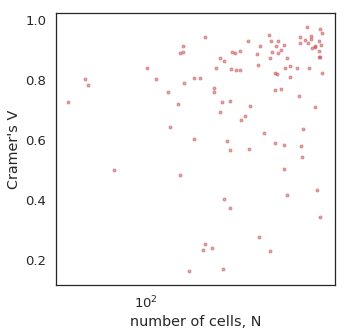

In [173]:
# plot correlation between number of cells and Cramers V
h2 = plt.figure(2,figsize=(5,5))
scat = plt.scatter(masterDF['N'], masterDF['CV'], color='r', marker='.', alpha=0.5)
xlab = plt.xlabel('number of cells, N')
ylab = plt.ylabel("Cramer's V")
xsca = plt.xscale("log")

## Simulate on an existing tree

## Look at reconstruction results

In [20]:
def network_to_cm(G):
    
    targets = get_leaves_of_tree(G)
    
    char_vecs = []
    names = []
    for t in targets:
        char_vecs.append(t.get_character_vec())
        names.append(t.name)
    
    M = len(char_vecs[0])
    cm = pd.DataFrame(char_vecs, columns = ['r' + str(i) for i in range(M)])
    cm.index = names
    
    return cm

ilp_fitch = defaultdict(list)
greedy_fitch = defaultdict(list)
mus = defaultdict(list)
nfitch = defaultdict(list)

true_net_dir = "/data/yosef2/users/mattjones/projects/scLineages/true_networks/400_samples/characters/trees/"
_recons_dir = "/data/yosef2/users/mattjones/projects/scLineages/stress_tests/400_samples/ilp_networks/characters/"
_recons_dir_greedy = "/data/yosef2/users/mattjones/projects/scLineages/stress_tests/400_samples/greedy_networks/characters/"

for rep in tqdm(range(2)):
    
    for i in tqdm(range(5)):
                
        sim_tree = pic.load(open(true_net_dir + "true_network_characters_40_run_" + str(rep) + ".pkl", 'rb'))
        sim_tree_met, params = data_gen.overlay_markov_chain(sim_tree, sample_list, max_mu = 0.3)
        
        cm = network_to_cm(sim_tree)
        
        ilp_tree = pic.load(open(_recons_dir + "ilp_network_characters_40_run_" + str(rep) + ".pkl", 'rb'))
        greedy_tree = pic.load(open(_recons_dir_greedy + "greedy_network_characters_40_run_" + str(rep) + ".pkl", 'rb'))
        
        n_mets, mets, freqs = get_transition_stats(sim_tree_met.network)
        
        leaves = [n for n in sim_tree_met.network if sim_tree_met.network.out_degree(n) == 0]
        meta = pd.DataFrame.from_dict(dict(zip([l.name for l in leaves], [sim_tree_met.network.nodes[l]['meta'] for l in leaves])), orient='index', columns = ['sample'])
        
        norm_fitch = met_utils.compute_dynamic_metastasis_score(sim_tree_met.network, meta['sample'])
        
        # append meta to reconstructed tree
        ilp_tree = Cassiopeia_Tree("ilp", network=ilp_tree).post_process(cm).network
        greedy_tree = Cassiopeia_Tree("greedy", network=greedy_tree).post_process(cm).network
        
        # nn_met = met_utils.compute_NN_metastasis_score(reconstructed_tree, meta['sample'], _method = 'allele', verbose=False)
        norm_fitch_ilp = met_utils.compute_dynamic_metastasis_score(ilp_tree, meta['sample'])
        norm_fitch_greedy = met_utils.compute_dynamic_metastasis_score(greedy_tree, meta['sample'])
        
        nfitch[rep].append(norm_fitch)
        ilp_fitch[rep].append(norm_fitch_ilp)
        greedy_fitch[rep].append(norm_fitch_greedy)
        mus[rep].append(params['mu'])
        
        
        

100%|██████████| 2/2 [00:23<00:00, 11.79s/it]


In [21]:
recons_df = pd.DataFrame(columns=['rep', 'mu', 'nfitch', 'ilp_fitch', 'greedy_fitch'])

j = 0
for rep in ilp_fitch.keys():
    for i in range(len(ilp_fitch[rep])):
        mu = mus[rep][i]
        fi = ilp_fitch[rep][i]
        fg = greedy_fitch[rep][i]
        fn = nfitch[rep][i]
        
        recons_df.loc[j, 'rep'] = rep
        recons_df.loc[j, 'mu'] = mu
        recons_df.loc[j, 'nfitch'] = fn
        recons_df.loc[j, 'ilp_fitch'] = fi
        recons_df.loc[j, 'greedy_fitch'] = fg
    
        
        j += 1

recons_df.head(5)

,rep,mu,nfitch,ilp_fitch,greedy_fitch
0,0,0.297074,0.152796,0.186226,0.225023
1,0,0.279922,0.147594,0.177793,0.231323
2,0,0.110468,0.0988296,0.135629,0.160216
3,0,0.185603,0.116385,0.170766,0.193519
4,0,0.179887,0.128739,0.173577,0.207021


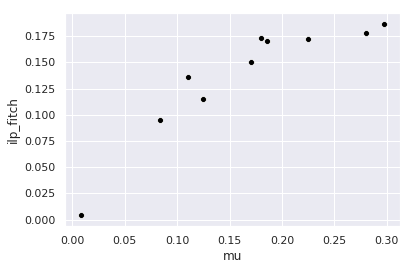

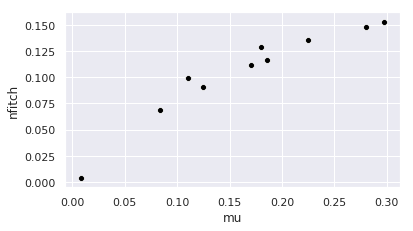

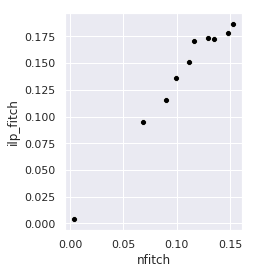

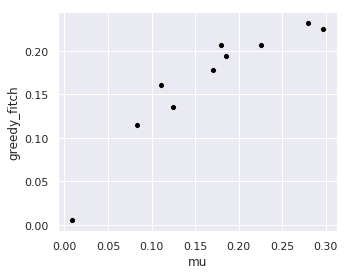

In [22]:
ax = sns.scatterplot(recons_df['mu'], recons_df['ilp_fitch'], color='black')
ax.set_aspect(1)
# plt.savefig('ilpfitch_vs_mu.png')
plt.show()


ax = sns.scatterplot(recons_df['mu'], recons_df['nfitch'], color='black')
ax.set_aspect(1)
# plt.savefig('truefitch_vs_mu.png')
plt.show()


ax = sns.scatterplot(recons_df['nfitch'], recons_df['ilp_fitch'], color='black')
ax.set_aspect(1)
# plt.savefig('truefitch_vs_ilpfitch.png')
plt.show()




h = plt.figure(figsize=(5,5))
ax = sns.scatterplot(recons_df['mu'], recons_df['greedy_fitch'], color='black')
ax.set_aspect(aspect=1)
plt.show()

### Look at bootstrap results 

In [39]:
def network_to_cm(G):
    
    targets = get_leaves_of_tree(G)
    
    char_vecs = []
    names = []
    for t in targets:
        char_vecs.append(t.get_character_vec())
        names.append(t.name)
    
    M = len(char_vecs[0])
    cm = pd.DataFrame(char_vecs, columns = ['r' + str(i) for i in range(M)])
    cm.index = names
    
    return cm

nfitch = defaultdict(dict)
mus = defaultdict(dict)
nns = []

true_net_dir = "/data/yosef2/users/mattjones/projects/scLineages/true_networks/400_samples/characters/trees/"
_recons_dir = "/data/yosef2/users/mattjones/projects/scLineages/stress_tests/400_samples/bootstrap/ilp/"
_cm_dir = "/data/yosef2/users/mattjones/projects/scLineages/stress_tests/400_samples/bootstrap/cms/"

# iterate over simulated trees 
for rep in tqdm(range(1)):
    
    # draw markov chains
    for i in tqdm(range(10)):

        recons_dir = _recons_dir + "cm" + str(rep+1) + "/"
        cm_dir = _cm_dir + "cm" + str(rep+1) + "/"
        
        sim_tree = pic.load(open(true_net_dir + "true_network_characters_40_run_" + str(rep) + ".pkl", 'rb'))

        sim_tree_met, params = data_gen.overlay_markov_chain(sim_tree, sample_list, max_mu = 0.3)

         #cm = network_to_cm(sim_tree_met.network)
            
        for b in tqdm(range(50)):
            
            cm = pd.read_csv(cm_dir + "bootstrap_" + str(b) + "_cm.txt", sep='\t', index_col = 0)
            
            reconstructed_tree = pic.load(open(recons_dir + "ilp_tree_cm" + str(rep+1) + "_" + str(b) + ".pkl", 'rb'))

            n_mets, mets, freqs = get_transition_stats(sim_tree_met.network)

            leaves = [n for n in sim_tree_met.network if sim_tree_met.network.out_degree(n) == 0]
            meta = pd.DataFrame.from_dict(dict(zip([l.name for l in leaves], [sim_tree_met.network.nodes[l]['meta'] for l in leaves])), orient='index', columns = ['sample'])

            # append meta to reconstructed tree
            # reconstructed_tree = Cassiopeia_Tree('simulated', network = reconstructed_tree).post_process(cm).network
            reconstructed_tree = reconstructed_tree.post_process(cm).network
            
            norm_fitch = met_utils.compute_dynamic_metastasis_score(reconstructed_tree, meta['sample'])
            
            if i not in nfitch[rep]:
                nfitch[rep][i] = []
                mus[rep][i] = []
                
            nfitch[rep][i].append(norm_fitch)
            mus[rep][i].append(params['mu'])
            # nns.append(nn_met)




  0%|          | 0/1 [00:00<?, ?it/s]



  0%|          | 0/10 [00:00<?, ?it/s]




  0%|          | 0/50 [00:00<?, ?it/s]




  2%|▏         | 1/50 [00:01<01:19,  1.63s/it]




  4%|▍         | 2/50 [00:02<01:13,  1.52s/it]




  6%|▌         | 3/50 [00:04<01:07,  1.44s/it]




  8%|▊         | 4/50 [00:05<01:04,  1.39s/it]




 10%|█         | 5/50 [00:06<01:03,  1.40s/it]




 12%|█▏        | 6/50 [00:08<00:59,  1.36s/it]




 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]




 16%|█▌        | 8/50 [00:10<00:55,  1.32s/it]




 18%|█▊        | 9/50 [00:11<00:52,  1.27s/it]




 20%|██        | 10/50 [00:13<00:52,  1.30s/it]




 22%|██▏       | 11/50 [00:14<00:50,  1.30s/it]




 24%|██▍       | 12/50 [00:15<00:47,  1.26s/it]




 26%|██▌       | 13/50 [00:16<00:47,  1.27s/it]




 28%|██▊       | 14/50 [00:18<00:45,  1.27s/it]




 30%|███       | 15/50 [00:19<00:45,  1.30s/it]




 32%|███▏      | 16/50 [00:20<00:43,  1.28s/it]




 34%|███▍      | 17/50 [00:22<00:42,  1.28s/it]

In [48]:
# convert nested dictionary to dataframe 
boot_df = pd.DataFrame(columns=['rep', 'mu', 'boot', 'nfitch'])
j = 0
for rep in nfitch.keys():
    for i in nfitch[rep].keys():
        
        
        nfitches = nfitch[rep][i]
        mu_set = mus[rep][i]
        for b in range(len(nfitch[rep][i])):
            boot_df.loc[j, 'rep'] = rep
            boot_df.loc[j, 'mu'] = mu_set[b]
            boot_df.loc[j, 'boot'] = b
            boot_df.loc[j, 'nfitch'] = nfitches[b]
        
            j += 1

boot_df.head(5)

,rep,mu,boot,nfitch
0,0,0.0907902,0,0.100356
1,0,0.0907902,1,0.105784
2,0,0.0907902,2,0.117871
3,0,0.0907902,3,0.108984
4,0,0.0907902,4,0.108397
